In [1]:
!pip install ultralytics easyocr opencv-python pillow --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 18.4 MB/s eta 0:00:00


In [2]:
import io
import re
import cv2
import numpy as np
import easyocr
import string
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
LATIN_CHARS = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

PROVINCES = [
    "BAGMATI","KOSHI","GANDAKI","KARNALI",
    "LUMBINI","SUDURPASHCHIM","MADHESH",
    "STATE1","STATE2","STATE3","STATE4","STATE5","STATE6","STATE7"
]

CONFUSION_MAP = {
    '0': ['O', 'Q', 'D','G'],
    '1': ['I', 'L', '|'],
    '2': ['Z'],
    '5': ['S'],
    '6': ['G', 'C'],
    '8': ['B'],
    '9': ['g'],
    'A': ['4'],
    'O': ['0'],
    'I': ['1', 'l'],
    'S': ['5'],
    'B': ['8','3'],
    'G': ['6','0'],
    'Z': ['2'],
    'D': ['0'],
    'Q': ['0']
}

def clean_input(text):
    ALLOWED_CHARS = string.ascii_uppercase + string.digits
    text = text.upper().strip()
    text = re.sub(r'[^A-Z0-9]', '', text)

    for p in PROVINCES:
        text = text.replace(p, "")

    text = text.replace("NEP", "")
    text = "".join([c for c in text if c in ALLOWED_CHARS])
    return text

def correct_plate(text: str):
    if len(text) >= 7:
        text = text[-7:]

    corrected = list(text)

    # First 3 letters
    for i in range(min(3, len(corrected))):
        if corrected[i].isdigit():
            for k, v in CONFUSION_MAP.items():
                if k.isalpha() and corrected[i] in v:
                    corrected[i] = k
                    break

    # Last 4 digits
    for i in range(len(corrected)-4, len(corrected)):
        if i >= 0 and corrected[i].isalpha():
            for k, v in CONFUSION_MAP.items():
                if k.isdigit() and corrected[i] in v:
                    corrected[i] = k
                    break

    return "".join(corrected)


In [13]:
reader = easyocr.Reader(['en'], gpu=False)
model = YOLO("best.pt")


In [27]:
from google.colab import files

uploaded = files.upload()
image_name = list(uploaded.keys())[0]


Saving sample15.png to sample15.png



0: 288x640 1 License_Plate, 133.4ms
Speed: 3.3ms preprocess, 133.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


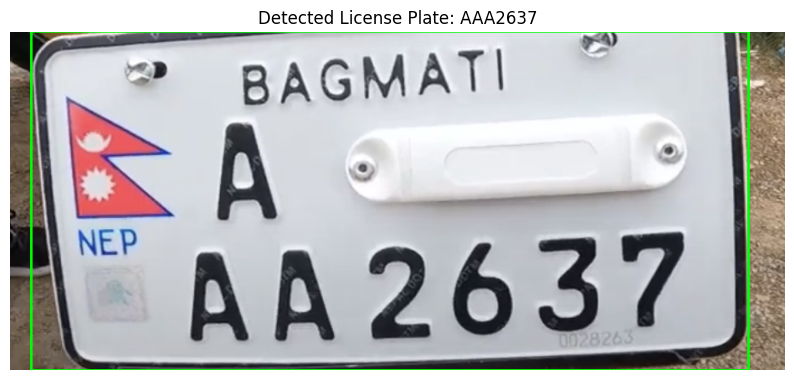

In [29]:
# Load image
image = Image.open(image_name).convert("RGB")
img_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# YOLO detection
results = model(img_np)[0]

if len(results.boxes) == 0:
    print("❌ No license plate detected")
else:
    x1, y1, x2, y2 = map(int, results.boxes[0].xyxy[0])

    plate_crop = img_np[y1:y2, x1:x2]
    gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=1)


# OCR
ocr_results = reader.readtext(eroded, paragraph=False)


if not ocr_results:
    print("❌ OCR failed to find text")
else:
    box_data = []
    full_text = ''
    for (bbox, text, conf) in ocr_results:
        if conf < 0.2: continue # Ignore very low confidence
        full_text += text + " "

        full_text = full_text.strip().upper()


        cleaned = clean_input(full_text)
        final_plate = correct_plate(cleaned)



    # Draw bounding box
    vis_img = img_np.copy()
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(
        vis_img,
        f"Plate: {final_plate}",
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0,255,0),
        2
    )

    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Detected License Plate: {final_plate}")
    plt.show()

